In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 3.1: Add a Bit of Variation: Write your first hybrid variational program

In [2]:
# EXERCISE 1 SOLUTION

@cudaq.kernel
def initial_state(qubits : cudaq.qview):
    """ Apply gates to the qubits to prepare the GHZ state
    Parameters
        qubits: cudaq.qvector
        qubits for the walker
    """
    # Edit the code below this line
    h(qubits[0])
    for i in range(len(qubits)-1):
        x.ctrl(qubits[0], qubits[i+1])
    
    # Edit the code above this line

In [6]:
# EXERCISE 2 SOLUTION

# Define a kernel on 4 qubits for the DEC operation that
# maps |x> to |x-1> mod 16 and verify that it works as expected for |0001>

@cudaq.kernel
def DEC(qubits : cudaq.qview):
    # Edit the code below this line
    x(qubits[3])
    x.ctrl(qubits[3], qubits[2])
    x.ctrl([qubits[3], qubits[2]], qubits[1])
    x.ctrl([qubits[3], qubits[2], qubits[1]], qubits[0])
    # Edit the code above this line

# Create a kernel that applies the DEC to the 4 qubit state |0000>
@cudaq.kernel
def check_decrementer_kernel():
    qubits = cudaq.qvector(4)
    # Initialize the qubits to |0001>
    x(qubits[3])
    DEC(qubits)

result = cudaq.sample(check_decrementer_kernel).most_probable()
print('Decrementer kernel |0001> -> |{}>'.format(result))

Decrementer kernel |0001> -> |0000>


In [9]:
# EXERCISE 3 SOLUTION
# Fill in the code to carry out the S- step

# Pick your favorite values
theta = np.pi/4     #CHANGE ME
phi = np.pi/4       #CHANGE ME  
lam = 0.0          #CHANGE ME

# Set the number of qubits
num_qubits = 4

@cudaq.kernel
def DTQW_one_step(num_qubits: int, theta : float, phi : float, lam : float):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qvector(1)
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])
        
    # Initial coin state    
    #h(coin_qubit[0]) #Uncomment this line to start with a superposition of heads and tails instead of |0>
        
    # One quantum walk step
    # Coin operation F=u3
    u3(theta, phi, lam, coin_qubit)
    
    # Walker's position change  
    # Shift right (S+) when the coin is |1>
    cudaq.control(INC, coin_qubit[0], walker_qubits)
    
    # Shift left (S-) when the coin is |0>
    # EDIT CODE BELOW THIS LINE

    x(coin_qubit[0])
    cudaq.control(DEC, coin_qubit[0], walker_qubits)
    x(coin_qubit[0])
    
    # EDIT CODE ABOVE THIS LINE
    
    mz(walker_qubits)

# Visualize the kernel for the quantum walk
print(cudaq.draw(DTQW_one_step, num_qubits, theta, phi, lam))

# Sample the kernel for the quantum walk
result = cudaq.sample(DTQW_one_step, num_qubits, theta, phi, lam, shots_count=1000)
print(result)

                            ╭───╮                                   ╭───╮     
q0 : ───────────────────────┤ x ├───────────────────────────────────┤ x ├─────
              ╭───╮         ╰─┬─╯╭───╮                         ╭───╮╰─┬─╯     
q1 : ─────────┤ x ├───────────●──┤ x ├─────────────────────────┤ x ├──●───────
              ╰───╯           │  ╰─┬─╯╭───╮               ╭───╮╰─┬─╯  │       
q2 : ─────────────────────────●────●──┤ x ├───────────────┤ x ├──●────●───────
              ╭───╮           │    │  ╰─┬─╯╭───╮     ╭───╮╰─┬─╯  │    │       
q3 : ─────────┤ x ├───────────●────●────●──┤ x ├─────┤ x ├──●────●────●───────
     ╭────────┴───┴────────╮  │    │    │  ╰─┬─╯╭───╮╰─┬─╯  │    │    │  ╭───╮
q4 : ┤ u3(0.7854,0.7854,0) ├──●────●────●────●──┤ x ├──●────●────●────●──┤ x ├
     ╰─────────────────────╯                    ╰───╯                    ╰───╯

{ 0100:861 0110:139 }



{ 0001:5346 0011:2330 0101:885 0111:557 1001:882 }



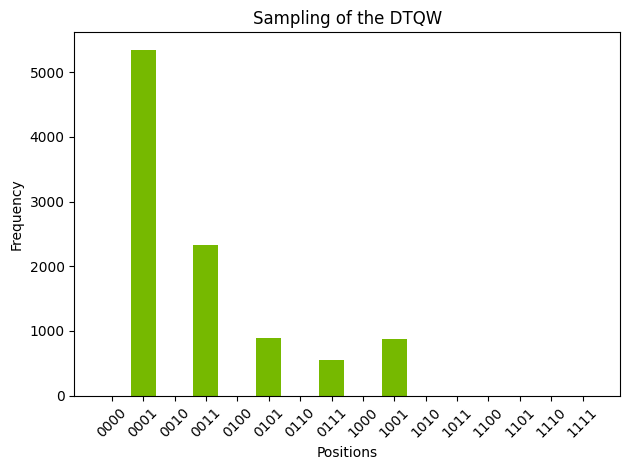

In [198]:
# EXERCISE 4 SOLUTION

# Set a variable for the number of time steps
num_time_steps = 4 # CHANGE ME to see the effect of different length walks

# Pick your favorite values
theta = np.pi/4     #CHANGE ME
phi = np.pi/4       #CHANGE ME  
lam = 0.0          #CHANGE ME

# Set the number of qubits
num_qubits = 4

# EDIT CODE BELOW THIS LINE
@cudaq.kernel()
def DTQW_multi_step(num_qubits: int, theta : float, phi : float, lam : float, num_time_steps : int):
    walker_qubits = cudaq.qvector(num_qubits)
    coin_qubit = cudaq.qvector(1)
    # Initial walker state |0101>
    x(walker_qubits[1])
    x(walker_qubits[3])
        
    # Initial coin state    
    #h(coin_qubit[0]) #Uncomment this line to start with a superposition of heads and tails instead of |0>
    
    # Flip the coin num_time_steps and shift the walker accordingly
    for _ in range(num_time_steps):
        
        # One quantum walk step
        # Coin operation F=u3
        u3(theta, phi, lam, coin_qubit)
    
        # Walker's position change 
        # Shift right (S+) when the coin is |1>
        cudaq.control(INC, coin_qubit[0], walker_qubits)
    
        # Shift left (S-) when the coin is |0>

        x(coin_qubit[0])
        cudaq.control(DEC, coin_qubit[0], walker_qubits)
        x(coin_qubit[0])
    
   
    # Measure the state of the walker
    mz(walker_qubits)

# EDIT CODE ABOVE THIS LINE

# Sample the kernel for the quantum walk
result_multi_step = cudaq.sample(DTQW_multi_step, num_qubits, theta, phi, lam, num_time_steps, shots_count=10000)
print(result_multi_step)

# Draw the histogram of the results after one step
plot_results(result_multi_step, num_qubits)